## MSCA 31008 - Data Mining Principles - Course Project

### Predicting Pet Adoption Speed at Pet Shelters : Modelling
### Submitted by:

Saurabh Srivastava
Raghav Atal
Rima Mittal
Tobel Ezeokoli

@uchicago.edu

### Import required packages and import data processed by the feature engineering notebook

In [4]:
import pickle
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,GroupKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
pd.set_option('max_columns',500)

In [40]:
#Read the train and test cleaned data with engineered features
train_copy_df = pd.read_csv('train_complete.csv')
test_copy_df = pd.read_csv('test_complete.csv')

In [6]:
train_copy_df.head()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,DescrLength,Description,Dewormed,Fee,FurLength,Gender,Health,IsHealthy,IsMixedBreed,Magnitude,MaturitySize,Name,NameFrequency,NumColors,PetID,PhotoAmt,Quantity,RescuerID,Score,State,StateLevel,Sterilized,Type,Vaccinated,VideoAmt,WordCount,RescuerNumPosts,BreedRank,detectionConfidence,joyLikelihood,sorrowLikelihood,angerLikelihood,surpriseLikelihood,underExposedLikelihood,blurredLikelihood,headwearLikelihood,labels,street dog,dog like mammal,aegean cat,carnivoran,small to medium sized cats,cat like mammal,dog breed,snout,whiskers,domestic short haired cat,puppy,dog breed group,fauna,kitten,european shorthair,dog,sporting group,cat
0,2,3,299,0,1,7,0,359,Nibble is a 3+ month old ball of cuteness. He ...,2,100,1,1,1,7,0,2.4,1,Nibble,1,2,86e1089a3,1,1,3734,0.3,41326,0,2,2,2,0,69,8,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.000000,0.000000,0.0,0.000000,0.919535,0.894983,0.000000,0.000000,0.680083,0.74,0.000000,0.000000,0.000000,0.695694,0.0,0.000000,0.000000,0.990786
1,0,1,265,0,1,2,0,118,I just found it alone yesterday near my apartm...,3,0,2,1,1,10,0,0.7,2,No Name Yet,22,2,6296e909a,2,1,1408,-0.2,41401,1,3,2,3,0,23,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.000000,0.0,0.000000,0.891908,0.834615,0.000000,0.672995,0.905297,0.00,0.000000,0.658263,0.841606,0.000000,0.0,0.000000,0.000000,0.981269
2,3,1,307,0,2,7,0,393,Their pregnant mother was dumped by her irresp...,1,0,2,1,1,5,0,3.7,2,Brisco,1,2,3422e4906,7,1,6965,0.2,41326,0,2,1,1,0,69,459,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.941660,0.0,0.649802,0.000000,0.000000,0.941017,0.616009,0.000000,0.00,0.720260,0.903123,0.000000,0.000000,0.0,0.960457,0.000000,0.000000
3,2,4,307,0,1,2,0,146,"Good guard dog, very alert, active, obedience ...",1,150,1,2,1,5,0,0.9,2,Miko,11,2,5842f1ff5,8,1,4107,0.9,41401,1,2,1,1,0,25,50,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.583048,0.946035,0.0,0.655879,0.000000,0.000000,0.938040,0.677403,0.000000,0.00,0.858104,0.874950,0.000000,0.000000,0.0,0.978698,0.546364,0.000000
4,2,1,307,0,1,0,0,390,This handsome yet cute boy is up for adoption....,2,0,1,1,1,7,0,3.7,2,Hunter,5,1,850a43f90,3,1,4191,0.6,41326,0,2,1,2,0,81,134,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.965755,0.0,0.661956,0.000000,0.000000,0.942495,0.783549,0.000000,0.00,0.932304,0.902654,0.000000,0.000000,0.0,0.984346,0.000000,0.000000


Drop columns from predcitors including preiction variable, unique identifiers, text (converted to scores), Name and Quantity

In [7]:
drop_cols = ['AdoptionSpeed','Description','Name','PetID','Quantity']

In [8]:
#Drop columns and verify shape for train and test datasets
y = train_copy_df['AdoptionSpeed']
X = train_copy_df.drop(drop_cols,axis=1)
test_X = test_copy_df.drop(drop_cols, axis=1)
print(X.shape,y.shape,test_X.shape)

(14993, 57) (14993,) (3948, 57)


In [9]:
# Define what will be the final predicted train and test values
train_meta = np.zeros(y.shape)
test_meta = np.zeros(test_X.shape[0])

# Choose and initialize a model.
clf = XGBClassifier(max_depth=7,n_estimators=250,n_jobs=4)

# Divide the training data into k-folds, k=4 here.
kfold4 = StratifiedKFold(n_splits=4, shuffle=True, random_state=1812).split(X, y)
splits = list(kfold4)

# Loop over the folds and fit the model to the fold's training data.
# Then evaluate that model on i) the validation data of that fold, 
# and ii) on all of the test data.
for idx, (train_idx, valid_idx) in enumerate(splits):
        # The training and validation sets for this fold
        X_train = X.iloc[train_idx]
        y_train = y[train_idx]
        X_val = X.iloc[valid_idx]
        y_val = y[valid_idx]
              
        # Fit the model
        clf.fit(X_train, y_train)
        
        # Look at the validation kappa and accuracy with classes right from the model
        y_pred = clf.predict(X_val)
        print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
        
        # Assign real-valued classes in addition to the integer classes of y_pred.
        # Start with the predicted probabilities by class
        y_probs = clf.predict_proba(X_val)
        # and get the class values (use a copy incase we change values)
        class_vals = clf.classes_.copy()
        # Change the ordinal weight of class 0 to be -1 as researched.       
        class_vals[0] = -1
        # Create the float class values as the probability-weighted class
        # Here a python "list comprehension" is used rather than a loop.
        y_floats = [sum(y_probs[ix]*class_vals) for ix in range(len(y_probs[:,0]))]
        #   
        # Save these y_float values instead of the y_pred integers;
        ##train_meta[valid_idx] = y_pred.reshape(-1)
        train_meta[valid_idx] = y_floats
        # the predictions for just this validation fold are saved in the train_meta array;
        # looping over all folds will provide one prediction for each training sample.

        # Now use this fold's same model to generate Test predictions.
      
        # Instead of integer classes, get the predicted probabilites
        test_probs = clf.predict_proba(test_X)
        # and turn these into float class values.
        # Unlike the validation case, we get a test prediction from every fold,
        # so those float predictions are averaged. python list comprehension is used again.
        test_meta += np.array([sum(test_probs[ix]*class_vals) for ix in range(len(test_probs[:,0]))]) / len(splits)

Fold 0: accuracy = 43.9%, kappa = 0.3997  (no boundary adjustment)
Fold 1: accuracy = 43.4%, kappa = 0.4013  (no boundary adjustment)
Fold 2: accuracy = 43.6%, kappa = 0.3733  (no boundary adjustment)
Fold 3: accuracy = 43.5%, kappa = 0.3724  (no boundary adjustment)


***Saved Output:***<br>
Fold 0: accuracy = 43.9%, kappa = 0.3997  (no boundary adjustment)<br>
Fold 1: accuracy = 43.4%, kappa = 0.4013  (no boundary adjustment)<br>
Fold 2: accuracy = 43.6%, kappa = 0.3733  (no boundary adjustment)<br>
Fold 3: accuracy = 43.5%, kappa = 0.3724  (no boundary adjustment)<br>

Define functions to calculate class boundaries and also to assign class based on these boundaries for the predicted variable.

In [10]:
def get_class_bounds(y, y_pred, N=5, class0_fraction=-1):
    """
    Find boundary values for y_pred to match the known y class percentiles.
    Returns N-1 boundaries in y_pred values that separate y_pred
    into N classes (0, 1, 2, ..., N-1) with same percentiles as y has.
    Can adjust the fraction in Class 0 by the given factor (>=0), if desired. 
    """
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

def assign_class(y_pred, boundaries):
    """
    Given class boundaries in y_pred units, output integer class values
    """
    y_classes = np.zeros(len(y_pred))
    for iclass, bound in enumerate(boundaries):
        y_classes[y_pred >= bound] = iclass + 1
    return y_classes.astype(int)

This cell calculates and plots the kappa (and MSE) vs the class0 fraction adjustment.
Note that MSE prefers (lower MSE) a class0 fraction near/at 0,
whereas kappa prefers (higher kappa) a fraction near 1.
Then the class0 fraction that gives best training kappa is selected.

In [11]:
train_y = y
df_train = train_copy_df

# Save values of kappa, MSE, and accuracy vs the class0 fraction
kappas = []
mses = []
accurs = []
# fractions to try... (could go larger than 1 if desired.)
cl0fracs = np.array(np.arange(0.01,1.001,0.01))
for cl0frac in cl0fracs:
    boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
    train_meta_ints = assign_class(train_meta, boundaries)
    kappa = cohen_kappa_score(df_train['AdoptionSpeed'], train_meta_ints, weights='quadratic')
    kappas.append(kappa)
    mse = mean_squared_error(df_train['AdoptionSpeed'], train_meta_ints)
    mses.append(mse)
    accur = accuracy_score(df_train['AdoptionSpeed'], train_meta_ints)
    accurs.append(accur)
    
# Use the class0 fraction that gives the highest training kappa
ifmax = np.array(kappas).argmax()
cl0frac = cl0fracs[ifmax]

print("Best kappa for class0 fraction = {:.4f}".format(cl0frac))

Best kappa for class0 fraction = 0.4400


Calculate adjusted class boundaries

In [12]:
# Skip class0_fraction adjustment and plotting cells aboveand may delete those two cells and just uncomment this line:
##cl0frac = 1.0

print("Using class0_fraction = {:.4f}, gives boundaries:".format(cl0frac))
boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
print(boundaries)

train_meta_ints = assign_class(train_meta, boundaries)
kappa = cohen_kappa_score(train_y, train_meta_ints, weights='quadratic')

print("Adjusted boundaries give:")
print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,
                                100.0*accuracy_score(train_y, train_meta_ints)))

Using class0_fraction = 0.4400, gives boundaries:
[1.4161065337248147, 2.069924421608448, 2.473400386516005, 2.8913984396494925]
Adjusted boundaries give:
kappa = 0.4451  (with accuracy = 40.6%)


Create confusion matrix for agreements

In [13]:
# Confusion Matrix
con_mat = confusion_matrix(train_y, train_meta_ints)

# Look at the number that are on the diagonal (exact agreement)
diag = 0.0
for id in range(5):
    diag += con_mat[id,id]
print("\nConfusion matrix - Columns are prediced 0, predicted 1, etc.\n")
print(con_mat)
print("")
print("\n{2:.2f}% = {0}/{1} are on the diagonal (= accuracy)".format(
        int(diag), con_mat.sum(), 100.0*diag/con_mat.sum()))


Confusion matrix - Columns are prediced 0, predicted 1, etc.

[[  32  144   97   71   66]
 [  91 1251  929  480  339]
 [  41 1102 1382  895  617]
 [   9  576 1036  940  698]
 [   7  247  593  873 2477]]


40.57% = 6082/14993 are on the diagonal (= accuracy)


Save final prediction from single model (XGBClassifier)

In [14]:
test_meta_ints = assign_class(test_meta, boundaries)
PetID = test_copy_df['PetID']
testAdoptionSpeed = pd.Series(data=test_meta_ints, name="AdoptionSpeed")

# Preparing data for Submission
Submission = pd.concat([PetID,testAdoptionSpeed],axis=1)
Submission.head(10)

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4
5,77a490ec9,4
6,28c4b1b13,4
7,d1eada628,3
8,d134dec34,4
9,bcd464bb8,2


In [15]:
# Submission XGB depth 7
Submission.to_csv("Submission7.csv", index=False)

Feature Importance


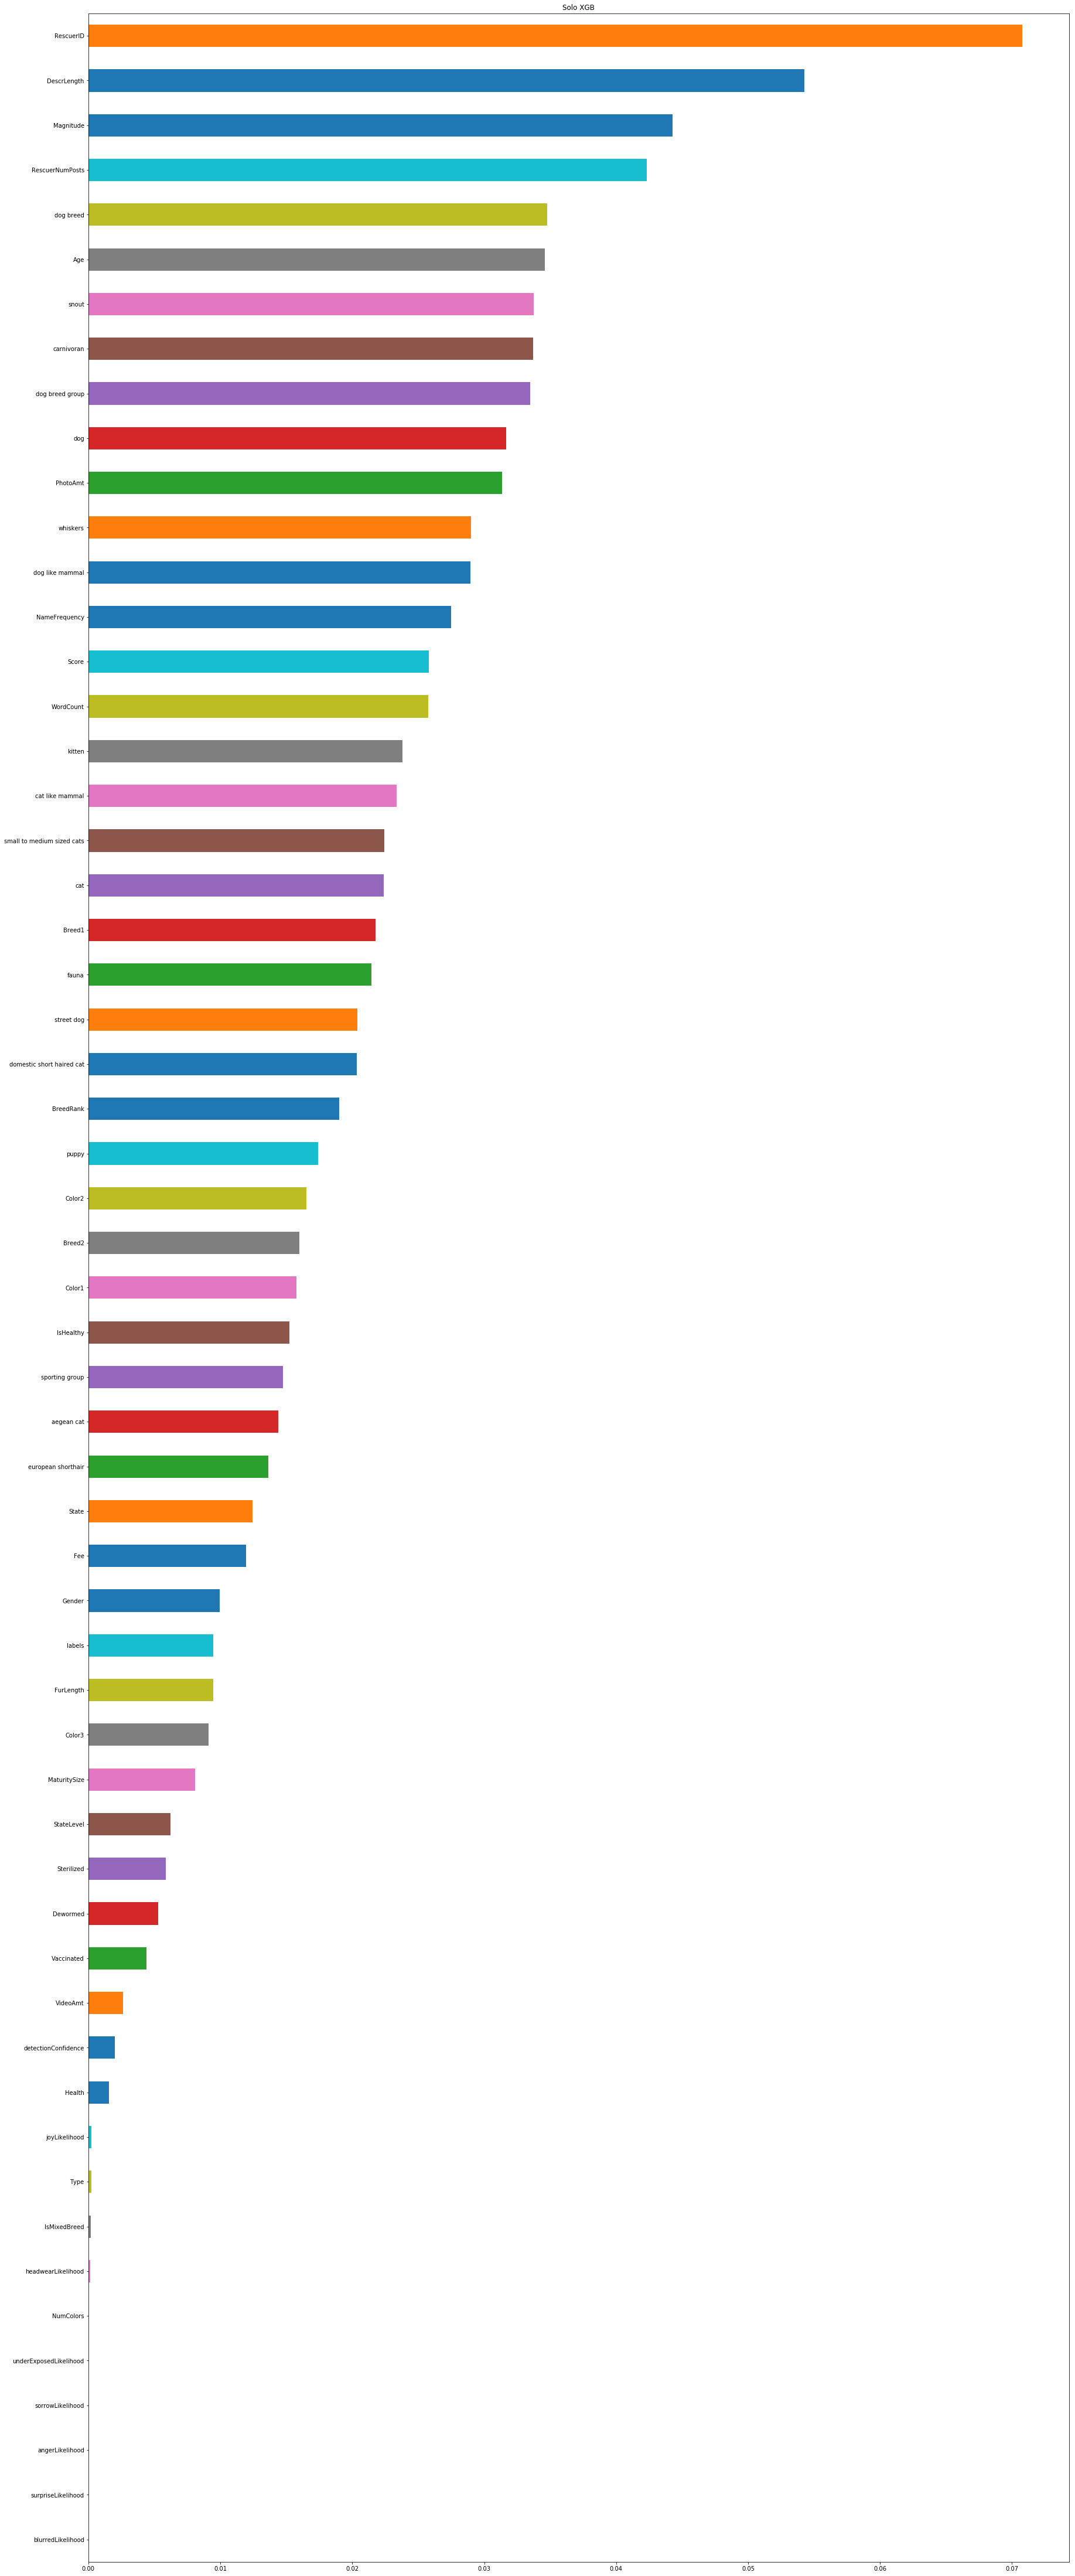

In [18]:
print("Feature Importance")
fig = plt.figure(figsize=(30,80))
# Create a pd.Series of features importances
importances_clf = pd.Series(clf.feature_importances_,
index = test_X.columns)
# Sort importances_rf
sorted_importances_clf = importances_clf.sort_values()
plt.title("Solo XGB")
# Make a horizontal bar plot
sorted_importances_clf.plot(kind='barh')

plt.show()

## Hyperparameter Tuning

Use four models - RF, XGB, ExtC and LGBM - and then ensemble voting results for final predictions

In [19]:
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
from collections import Counter
import pickle
%matplotlib inline

# Machine learning libraries
import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics
import sklearn         # Collection of machine learning algorithms
import sklearn.ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [20]:
#Copy test dataset
X_test = test_copy_df.drop(drop_cols, axis=1)

In [21]:
#Set seed for reproducability
SEED = 1812
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [22]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1812)

Model 1 - Decision Tree Classifier

In [23]:
#Decision Tree
DTClassifier = DecisionTreeClassifier()

param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

DTGrid = GridSearchCV(DTClassifier, param_grid, cv = kfold, n_jobs= -1, verbose = 1)

DTGrid.fit(X_train,Y_train)

# Best score
DT_best = DTGrid.best_estimator_
DTGrid.best_score_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 385 out of 400 | elapsed:    9.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.8s finished


0.3786059696514924

Model 2 - Extra Trees Classifier

In [24]:
# ExtraTrees 
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth': [6,7,8,9], 'max_features': [7,8,9,10],  
              'n_estimators': [50, 100, 200]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   41.7s finished


0.3992829748207437

Model 3 - Random Forest Classifier

In [25]:
# Random Forest
random_forest = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

gsrandom_forest = GridSearchCV(random_forest,param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsrandom_forest.fit(X_train,Y_train)
# Best score
random_forest_best = gsrandom_forest.best_estimator_
gsrandom_forest.best_score_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   11.5s finished


0.40895447723861933

In [58]:
gsrandom_forest.best_params_

{'max_depth': 8, 'max_features': 6, 'min_samples_split': 6}

Model 4 - XGBoost Classifier

In [26]:
#XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier()
param_grid = {'max_depth': [5,6,7], 'gamma': [1, 2], 'learning_rate': [0.1, 0.2, 0.3]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=kfold, verbose=1, n_jobs= 4)
xgb_grid.fit(X_train,Y_train)

# Best score
xgb_best = xgb_grid.best_estimator_
xgb_grid.best_score_

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:  8.8min finished


0.4317158579289645

In [38]:
xgb_grid.best_params_

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5}

In [27]:
# Save Grid Search models
pickle.dump(gsrandom_forest, open("Pet_Boost_RF.pkl", 'wb'))
pickle.dump(gsExtC, open("Pet_Boost_ExtC.pkl", 'wb'))
pickle.dump(xgb_grid, open("Pet_Boost_XGB.pkl", 'wb'))
pickle.dump(DTGrid, open("Pet_Boost_DT.pkl", 'wb'))

#### Plot learning curve of boosted model, by using sklearn's learning_curve function

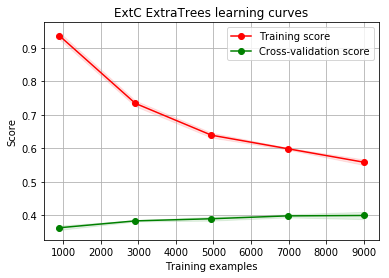

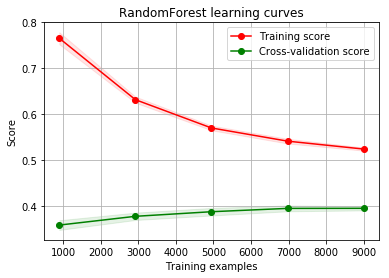

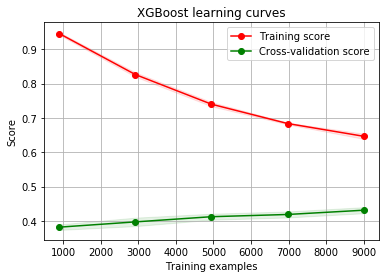

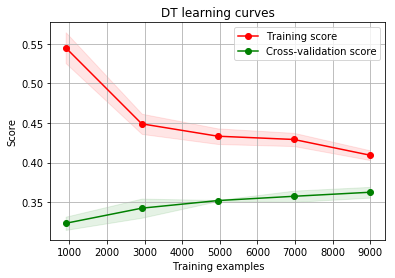

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsExtC.best_estimator_,"ExtC ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsrandom_forest.best_estimator_,"RandomForest learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(xgb_grid.best_estimator_,"XGBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(DTGrid.best_estimator_,"DT learning curves",X_train,Y_train,cv=kfold)

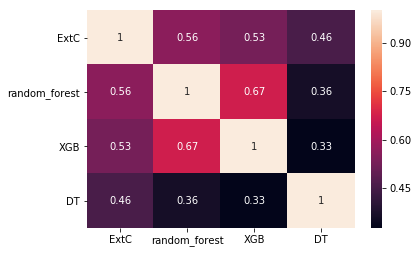

In [29]:
test_Adopted_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Adopted_random_forest = pd.Series(random_forest_best.predict(X_test), name="random_forest")
test_Adopted_XG = pd.Series(xgb_best.predict(X_test), name="XGB")
test_Adopted_DT = pd.Series(DT_best.predict(X_test), name="DT")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Adopted_ExtC, test_Adopted_random_forest, test_Adopted_XG, test_Adopted_DT],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

Create VotingClassifier below with three models and run fit on training set.

In [30]:
VotingPredictor = VotingClassifier(estimators=[('XGB', xgb_best),
                                               ('ExtC',ExtC_best), 
                                               ('DT',DT_best), 
                                               ('random_forest', random_forest_best)], voting='soft', n_jobs=4)
VotingPredictor = VotingPredictor.fit(X_train, Y_train)

Now we will run the voting classifier on the test set and save output.

In [31]:
VotingPredictor_predictions = VotingPredictor.predict(X_test)
test_AdoptionSpeed= pd.Series(VotingPredictor_predictions, name="AdoptionSpeed")
PetID = test_copy_df['PetID']

# Preparing data for Submission
Submission = pd.concat([PetID,test_Adopted_ExtC, test_Adopted_random_forest, test_Adopted_XG, test_Adopted_DT],axis=1)
Submission.head(10)

Submission.to_csv("EnsembleResuts.csv", index=False)

## Run Stacking to improve the productions

In [41]:
drop_cols = ['AdoptionSpeed','Description','Name','PetID','Quantity']

#Drop description, petid, name and prepare features, response and test set
y = train_copy_df['AdoptionSpeed']
X = train_copy_df.drop(drop_cols,axis=1)
test_X = test_copy_df.drop(drop_cols, axis=1)
#test_X = test_X.values
print(X.shape,y.shape,test_X.shape)

(14993, 57) (14993,) (3948, 57)


In [42]:
#Add M1_RF and M2_XGB features in both train and test features set
train_copy_df['M1_RF'] = np.NaN
train_copy_df['M2_XGB'] = np.NaN
train_copy_df['M3_DT'] = np.NaN
train_copy_df['M4_EXTC'] = np.NaN
train_copy_df['M5_GBM'] = np.NaN
test_copy_df['M1_RF'] = np.NaN
test_copy_df['M2_XGB'] = np.NaN
test_copy_df['M3_DT'] = np.NaN
test_copy_df['M4_EXTC'] = np.NaN
test_copy_df['M5_GBM'] = np.NaN



In [43]:
# Divide the training data into k-folds, k=4 here.
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=1812).split(X, y))

# Choose and initialize a model.
n_jobs=8
clf_XGB = XGBClassifier(max_depth=7,n_estimators=250,n_jobs=n_jobs)
clf_RF = RandomForestClassifier(bootstrap=True, criterion = 'gini', max_depth=80,
                             max_features='auto', min_samples_leaf=5,
                             min_samples_split=5, n_estimators=200,n_jobs=n_jobs)
#clf_SVM = SVC(C=1.0,kernel='rbf',probability=True)
clf_DT = DecisionTreeClassifier()
clf_EXTC = ExtraTreesClassifier(n_estimators=250,max_depth=80,n_jobs=n_jobs)
clf_GBM = GradientBoostingClassifier(learning_rate=0.1,n_estimators=200)

models = [('XGB',clf_XGB)
          ,('RF',clf_RF)
          ,('EXTC',clf_EXTC)
          ,('GBM',clf_GBM)
          ,('DT',clf_DT)
         ]

In [44]:
#Run all modelts to create predictions for each model


for (classfier_name,clf) in models:
    print('Running Model: {}'.format(classfier_name))
    train_meta = np.zeros(y.shape)
    test_meta = np.zeros(test_X.shape[0])
    for idx, (train_idx, valid_idx) in enumerate(splits): 
        X_train = X.iloc[train_idx]
        y_train = y[train_idx]
        X_val = X.iloc[valid_idx]
        y_val = y[valid_idx]
        
        # Fit the model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        y_probs = clf.predict_proba(X_val)
        print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
        
        class_vals = clf.classes_.copy()
        
        class_vals[0] = -1
        y_floats = [sum(y_probs[ix]*class_vals) for ix in range(len(y_probs[:,0]))]
               
        train_meta[valid_idx] = y_floats
            
        test_probs = clf.predict_proba(test_X)
        test_meta += np.array([sum(test_probs[ix]*class_vals) for
                               ix in range(len(test_probs[:,0]))]) / len(splits)
    train_y = y
    df_train = train_copy_df
    # Save values of kappa, MSE, and accuracy vs the class0 fraction
    kappas = []
    mses = []
    accurs = []
    # fractions to try... (could go larger than 1 if desired.)
    cl0fracs = np.array(np.arange(0.01,1.001,0.01))
    for cl0frac in cl0fracs:
        boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
        train_meta_ints = assign_class(train_meta, boundaries)
        kappa = cohen_kappa_score(df_train['AdoptionSpeed'], train_meta_ints, weights='quadratic')
        kappas.append(kappa)
        mse = mean_squared_error(df_train['AdoptionSpeed'], train_meta_ints)
        mses.append(mse)
        accur = accuracy_score(df_train['AdoptionSpeed'], train_meta_ints)
        accurs.append(accur)

    # Use the class0 fraction that gives the highest training kappa
    ifmax = np.array(kappas).argmax()
    cl0frac = cl0fracs[ifmax]

    print("Best kappa for class0 fraction = {:.4f}".format(cl0frac))
    boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
    train_meta_ints = assign_class(train_meta, boundaries)
    test_meta_ints = assign_class(test_meta, boundaries)
    if classfier_name == 'XGB':
        train_copy_df['M2_XGB'] = train_meta_ints
        test_copy_df['M2_XGB'] = test_meta_ints
    elif classfier_name == 'RF':
        train_copy_df['M1_RF'] = train_meta_ints
        test_copy_df['M1_RF'] = test_meta_ints
    elif classfier_name == 'SVM':
        train_copy_df['M3_SVM'] = train_meta_ints
        test_copy_df['M3_SVM'] = test_meta_ints
    elif classfier_name == 'EXTC':
        train_copy_df['M4_EXTC'] = train_meta_ints
        test_copy_df['M4_EXTC'] = test_meta_ints
    elif classfier_name == 'GBM':
        train_copy_df['M5_GBM'] = train_meta_ints
        test_copy_df['M5_GBM'] = test_meta_ints
    
    kappa = cohen_kappa_score(train_y, train_meta_ints, weights='quadratic')
    print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,100.0*accuracy_score(train_y, train_meta_ints)))
              

Running Model: XGB
Fold 0: accuracy = 43.9%, kappa = 0.3997  (no boundary adjustment)
Fold 1: accuracy = 43.4%, kappa = 0.4013  (no boundary adjustment)
Fold 2: accuracy = 43.6%, kappa = 0.3733  (no boundary adjustment)
Fold 3: accuracy = 43.5%, kappa = 0.3724  (no boundary adjustment)
Best kappa for class0 fraction = 0.4400
kappa = 0.4451  (with accuracy = 40.6%)
Running Model: RF
Fold 0: accuracy = 44.0%, kappa = 0.3793  (no boundary adjustment)
Fold 1: accuracy = 42.9%, kappa = 0.3783  (no boundary adjustment)
Fold 2: accuracy = 43.8%, kappa = 0.3501  (no boundary adjustment)
Fold 3: accuracy = 43.0%, kappa = 0.3490  (no boundary adjustment)
Best kappa for class0 fraction = 0.7300
kappa = 0.4237  (with accuracy = 37.7%)
Running Model: EXTC
Fold 0: accuracy = 42.9%, kappa = 0.3627  (no boundary adjustment)
Fold 1: accuracy = 42.7%, kappa = 0.3506  (no boundary adjustment)
Fold 2: accuracy = 44.0%, kappa = 0.3562  (no boundary adjustment)
Fold 3: accuracy = 42.9%, kappa = 0.3574  (no 

In [76]:
#This cell fits  Random Forest classifier on top of the predictions of other models
#thereby stacking the models to get better predictions

train_copy_df[['AdoptionSpeed','M1_RF','M2_XGB']]
y_lr = train_copy_df['AdoptionSpeed']
#cols = ['M1_RF','M2_XGB','M4_EXTC','M5_GBM']
cols = ['RescuerID','M1_RF','M2_XGB','M4_EXTC','M5_GBM']
X_lr = train_copy_df[cols]

#stack_clf = RandomForestClassifier(max_depth=30,max_features='auto', n_estimators=500,random_state=0)

stack_clf = XGBClassifier(max_depth=3,n_estimators=300,n_jobs=n_jobs)

train_meta = np.zeros(y.shape)
test_meta = np.zeros(test_X.shape[0])

X_test_lr = test_copy_df[cols]

for idx, (train_idx, valid_idx) in enumerate(splits):
    X_train = X_lr.iloc[train_idx]
    y_train = y_lr[train_idx]
    X_val = X_lr.iloc[valid_idx]
    y_val = y_lr[valid_idx]
    stack_clf.fit(X_train,y_train)
    y_pred = stack_clf.predict(X_val)
    print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
    y_probs = stack_clf.predict_proba(X_val)
    class_vals = stack_clf.classes_.copy()

    #class_vals[0] = -1
    y_floats = [sum(y_probs[ix]*class_vals) for ix in range(len(y_probs[:,0]))]

    train_meta[valid_idx] = y_floats

    test_probs = stack_clf.predict_proba(X_test_lr)
    test_meta += np.array([sum(test_probs[ix]*class_vals) for
                           ix in range(len(test_probs[:,0]))]) / len(splits)
    
    
train_y = y_lr
df_train = train_copy_df
# Save values of kappa, MSE, and accuracy vs the class0 fraction
kappas = []
mses = []
accurs = []
# fractions to try... (could go larger than 1 if desired.)
cl0fracs = np.array(np.arange(0.01,1.001,0.01))
for cl0frac in cl0fracs:
    boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
    train_meta_ints = assign_class(train_meta, boundaries)
    kappa = cohen_kappa_score(df_train['AdoptionSpeed'], train_meta_ints, weights='quadratic')
    kappas.append(kappa)
    mse = mean_squared_error(df_train['AdoptionSpeed'], train_meta_ints)
    mses.append(mse)
    accur = accuracy_score(df_train['AdoptionSpeed'], train_meta_ints)
    accurs.append(accur)

# Use the class0 fraction that gives the highest training kappa
ifmax = np.array(kappas).argmax()
cl0frac = cl0fracs[ifmax]

print("Best kappa for class0 fraction = {:.4f}".format(cl0frac))
boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
train_meta_ints = assign_class(train_meta, boundaries)
test_meta_ints = assign_class(test_meta, boundaries)


kappa = cohen_kappa_score(train_y, train_meta_ints, weights='quadratic')
print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,
                            100.0*accuracy_score(train_y, train_meta_ints)))
# X_test_lr = test_copy_df[cols]
# y_test_pred_lr = stack_clf.predict(X_test_lr)
# np.unique(y_test_pred_lr,return_counts=True)

Fold 0: accuracy = 43.1%, kappa = 0.4250  (no boundary adjustment)
Fold 1: accuracy = 42.8%, kappa = 0.4138  (no boundary adjustment)
Fold 2: accuracy = 43.2%, kappa = 0.4171  (no boundary adjustment)
Fold 3: accuracy = 42.4%, kappa = 0.4075  (no boundary adjustment)
Best kappa for class0 fraction = 0.5200
kappa = 0.4539  (with accuracy = 40.5%)


In [79]:
test_meta_ints = assign_class(test_meta, boundaries)
PetID = test_copy_df['PetID']
testAdoptionSpeed = pd.Series(data=test_meta_ints, name="AdoptionSpeed")

# Preparing data for Submission
Submission = pd.concat([PetID,testAdoptionSpeed],axis=1)
Submission.head(10)

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4
5,77a490ec9,4
6,28c4b1b13,4
7,d1eada628,4
8,d134dec34,4
9,bcd464bb8,3


In [80]:
#writing submission output from Stacked model
Submission.to_csv("Submission35.csv", index=False)

**Plot Feature importance for all models used here**

Feature Importance


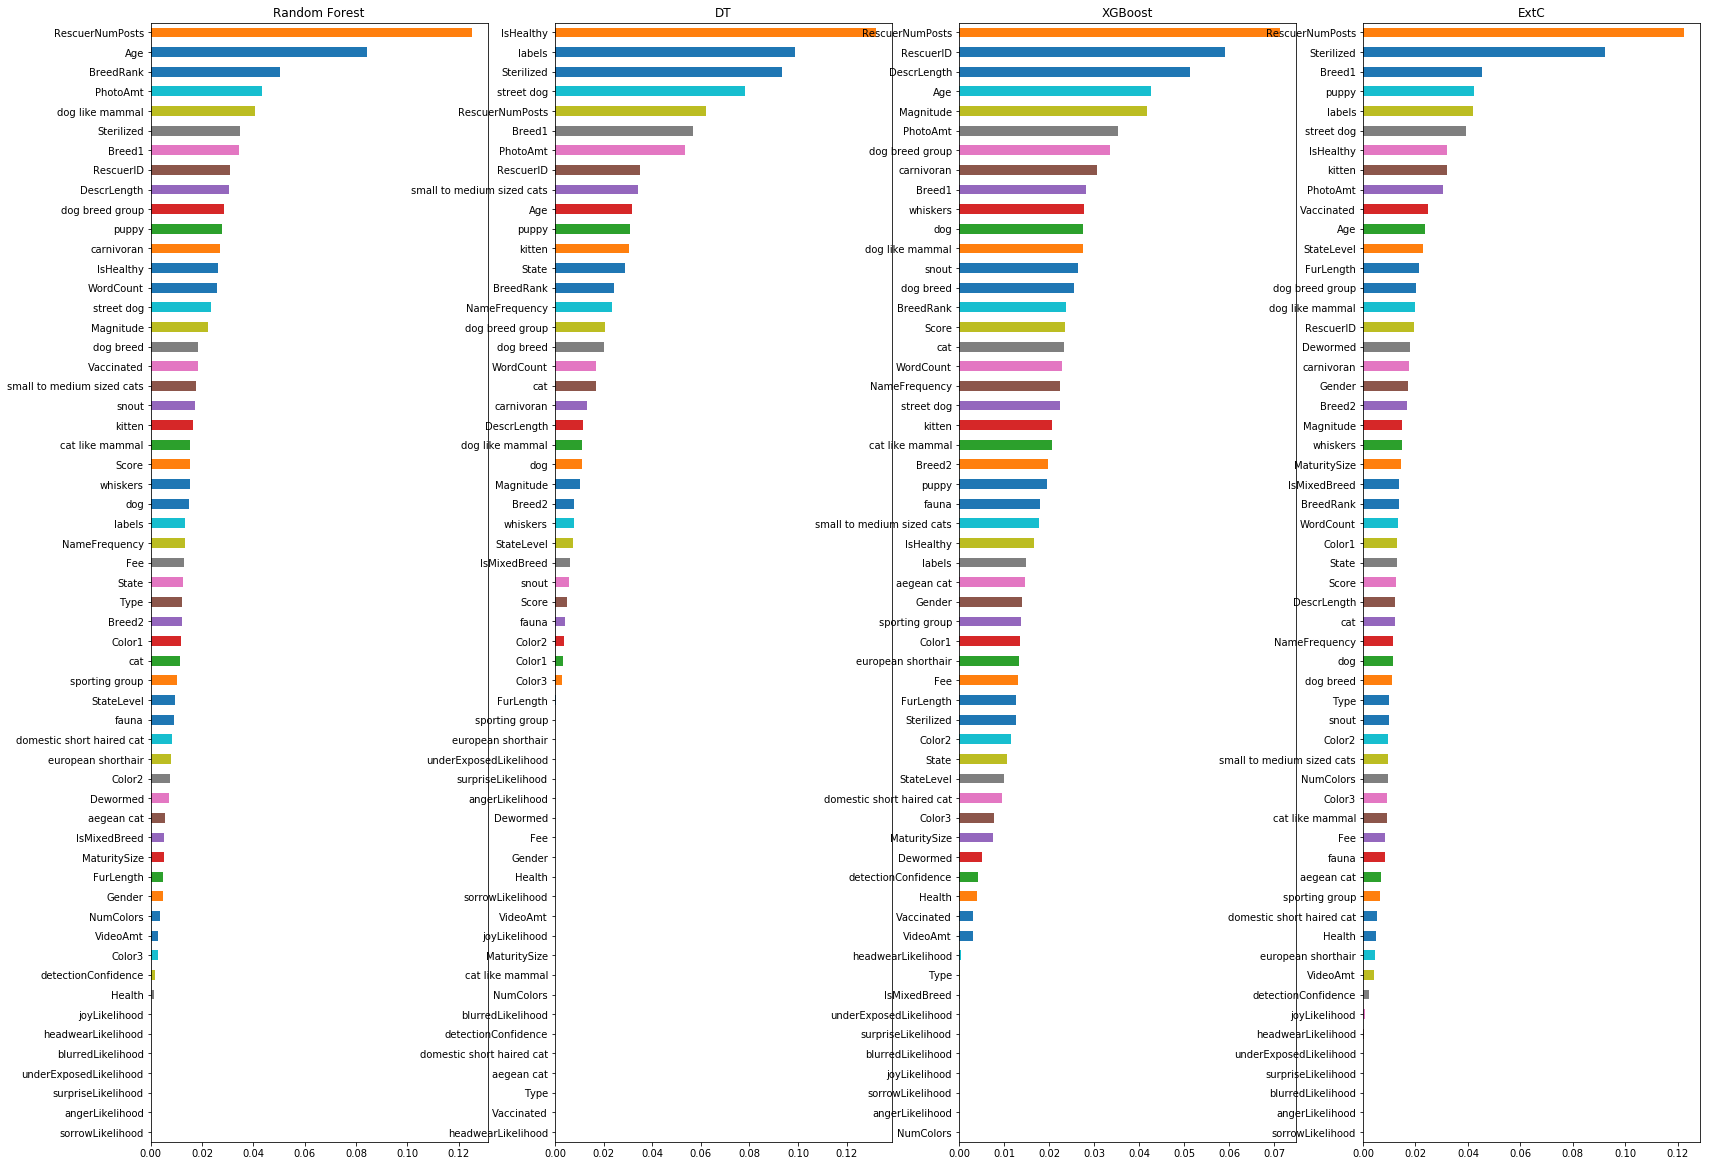

In [81]:
print("Feature Importance")
fig = plt.figure(figsize=(35,70))

plt.subplot(3, 5, 1)
# Create a pd.Series of features importances
importances_rf = pd.Series(random_forest_best.feature_importances_,
index = X_test.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
plt.title("Random Forest")
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh')

plt.subplot(3, 5, 2)
# Create a pd.Series of features importances
importances_dt = pd.Series(DT_best.feature_importances_,
index = X_test.columns)
# Sort importances
sorted_importances_dt = importances_dt.sort_values()
plt.title("DT")
# Make a horizontal bar plot
sorted_importances_dt.plot(kind='barh')


plt.subplot(3, 5, 3)
# Create a pd.Series of features importances
importances_xgb = pd.Series(xgb_best.feature_importances_,
index = X_test.columns)
# Sort importances_rf
sorted_importances_xgb = importances_xgb.sort_values()
plt.title("XGBoost")
# Make a horizontal bar plot
sorted_importances_xgb.plot(kind='barh')


plt.subplot(3, 5, 4)
# Create a pd.Series of features importances
importances_extc = pd.Series(ExtC_best.feature_importances_,
index = X_test.columns)
# Sort importances_rf
sorted_importances_extc = importances_extc.sort_values()
plt.title("ExtC")
# Make a horizontal bar plot
sorted_importances_extc.plot(kind='barh')

plt.show()